# Implementation of a VQ-VAE based on Jukebox by OpenAI

## Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# Utils
import numpy as np
from numpy import ndarray
import logging, math


# Base Scripts
from Libraries.Utils import *
from Libraries.VAE import *

## Setup

### Initial Setup

In [2]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
model_name: str = "VAE_v5"
full_model_path: str = OS().path_to_remote_path("../Models/{}.pth".format(model_name), remote_kernel)

### Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [4]:
n_samples: int = 2048
batch_size: int = 16
n_workers: int = 1

### Data loading

In [5]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split(n_samples)
train_datatset, val_dataset = md.create_datasets()
train_dataloader, val_dataloader = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")

2025-08-23 13:04:28,216 - INFO - Created train dataset with length 2048 and validation dataset with length 102


In [6]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-08-23 13:04:28,774 - INFO - Created test dataset with length 268


## Model Setup

### Hyperparameters

In [7]:
b1, b2 = (0.9, 0.99)
lr: float = 5e-5
free_bits: float = 0.1
C_max: float = 15
n_epochs: int = 120
checkpoint_freq: int = 15
gamma: float = 0.6
lr_restart_period: int = 30
restart_training: bool = True

### Models

In [8]:
vae = VAE(in_channels=1, downsample_factors=[2, 2, 2, 4], base_channels=32, latent_dim=4, n_layers=4).to(device)

### Optimizers & Schedulers

In [9]:
optimizer = optim.AdamW(vae.parameters(), lr, (b1, b2))
scheduler = optim.lr_scheduler.ConstantLR(optimizer, 1) #optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=lr_restart_period, eta_min=1e-7, T_mult=2)

### Load Model

In [10]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    vae.load_state_dict(model["vae"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(vae)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(vae)} Parameters")

2025-08-23 13:04:29,755 - INFO - Model VAE_v5 created with ~3.851M Parameters


## Training

In [11]:
torch.backends.cudnn.benchmark = True
stft_loss = MultiResolutionSTFTLoss()

def beta_C_warmup(epoch, warmup_epochs=50, beta_max=0.8, C_min=0.0, C_max=25.0):
    if epoch < 5:
        return 0.0, 0.0
    else:
        frac = (epoch - 5) / (warmup_epochs - 5)
        beta = beta_max * min(1.0, frac)
        C = C_max * min(1.0, frac * 0.2)  # C ramps slower than beta
        return beta, C





def vae_loss(recon: Tensor, x: Tensor, mu: Tensor, logvar: Tensor, stft_loss: nn.Module, free_bits: float = 0.08, beta: float = 0.003, gamma: float = 0.5, C: float = 0) -> tuple[Tensor, ...]:
    recon_loss = nn.L1Loss()(x,recon)
    kl_per_elem = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_per_dim = kl_per_elem.mean(dim=0)
    kl_dim_clamped = torch.clamp(kl_per_dim - free_bits, min=0)
    kl = kl_dim_clamped.mean()
    kl = nn.functional.relu(kl - C)
    percept = stft_loss(x, recon)
    return recon_loss + beta * kl + gamma * percept, recon_loss, kl, percept

def capacity_schedule(epoch: int, C_max: float, T: int) -> float:
    return min(C_max * epoch / T, C_max)


In [12]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0

for e in range(n_epochs):
    total_loss: float = 0
    total_percept: float = 0
    total_l1: float = 0
    total_kl: float = 0
    max_logvar: float = -torch.inf
    start_time: float = time.time()
    beta, C = beta_C_warmup(e)

    for b_idx, (audio, _) in enumerate(train_dataloader):
        audio: Tensor = audio.to(device)
        if audio.ndim == 2:
            audio = audio.unsqueeze(1)
        with torch.autocast(device):
            x_recon, mu, logvar = vae(audio)
            max_logvar = max(max_logvar, logvar.max().item())
            loss, l1, kl, percept = vae_loss(x_recon, audio, mu, logvar, stft_loss, free_bits, beta, gamma, C)
        if loss.isnan():
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
        total_percept += percept
        total_l1 += l1
        total_kl += kl
    else:
        vae.eval()
        total_val_loss: float = 0
        for x,_ in val_dataloader:
            audio: Tensor = audio.to(device)
            if audio.ndim == 2:
                audio = audio.unsqueeze(1)
            with torch.no_grad():
                x_recon, mu, logvar = vae(audio)
                loss, l1, kl, percept = vae_loss(x_recon, audio, mu, logvar, stft_loss, free_bits, beta, gamma, C)
                total_val_loss += loss
                if (e + 1) % 10 == 0:
                    AudioData(x_recon[0][0].cpu().numpy()).save_audio_file(f"Results/{model_name}_{e + 1}_Inference.wav")
                    z = torch.randn((10, *mu.shape[1:]), device=device)
                    samples = vae.decode(z)
                    AudioData(samples[0][0].cpu().numpy()).save_audio_file(f"Results/{model_name}_{e + 1}_Sample.wav")
                    
        vae.train()

        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
        avg_loss = total_loss / len(train_dataloader)
        avg_kl = total_kl / len(train_dataloader)
        avg_l1 = total_l1 / len(train_dataloader)
        avg_percept = total_percept / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        loss_list.append({"avg_loss": avg_loss, "avg_kl": avg_kl, "avg_l1": avg_l1, "avg_percept": avg_percept, "avg_val_loss": avg_val_loss})
        scheduler.step()

        logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.3e} KL Loss: {avg_kl:.3e} Percept. Loss: {avg_percept:.3e} Avg. Val Loss: {avg_val_loss:.3e} Beta: {beta:.3e} Max Logvar {max_logvar:.3e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.4e}")

        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
                checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
                torch.save({"vae": vae.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, checkpoint_path)
                if e + 1 != checkpoint_freq:
                    last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                    OS().del_if_exists(last_path)
                logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break
else:
    torch.save({"vae": vae.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)
    logger.light_debug(f"Saved model to {full_model_path}")

    if checkpoint_freq > 0:
        checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
        OS().del_if_exists(checkpoint_path)


2025-08-23 13:04:29,971 - INFO - Training started on cuda
2025-08-23 13:05:36,910 - INFO - Epoch 001: Avg. Loss: 9.620e-01 KL Loss: 2.757e+00 Percept. Loss: 1.470e+00 Avg. Val Loss: 7.353e-01 Beta: 0.000e+00 Max Logvar 1.000e+01 Remaining Time: 02h 11min 23s LR: 5.0000e-05
2025-08-23 13:06:37,551 - INFO - Epoch 002: Avg. Loss: 6.827e-01 KL Loss: 4.005e+00 Percept. Loss: 1.044e+00 Avg. Val Loss: 6.499e-01 Beta: 0.000e+00 Max Logvar 7.992e+00 Remaining Time: 02h 04min 05s LR: 5.0000e-05
2025-08-23 13:07:38,100 - INFO - Epoch 003: Avg. Loss: 6.100e-01 KL Loss: 5.028e+00 Percept. Loss: 9.338e-01 Avg. Val Loss: 5.830e-01 Beta: 0.000e+00 Max Logvar 8.656e+00 Remaining Time: 02h 00min 55s LR: 5.0000e-05
2025-08-23 13:08:38,614 - INFO - Epoch 004: Avg. Loss: 5.798e-01 KL Loss: 5.812e+00 Percept. Loss: 8.874e-01 Avg. Val Loss: 5.522e-01 Beta: 0.000e+00 Max Logvar 7.984e+00 Remaining Time: 01h 58min 49s LR: 5.0000e-05
2025-08-23 13:09:39,133 - INFO - Epoch 005: Avg. Loss: 5.628e-01 KL Loss: 6.42

KeyboardInterrupt: 

torch.Size([16, 1, 262144])
21.918935775756836
torch.Size([16, 1, 262144]) torch.Size([10, 1, 262144])
(262144,)


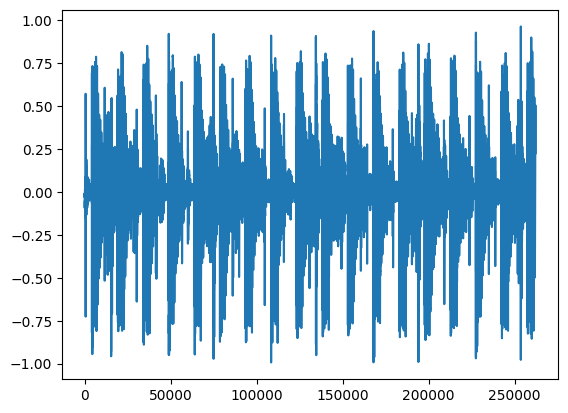

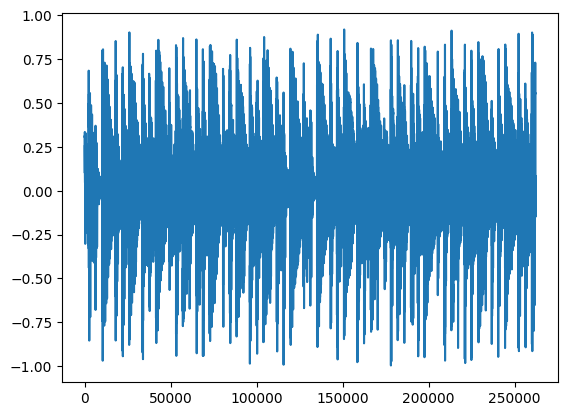

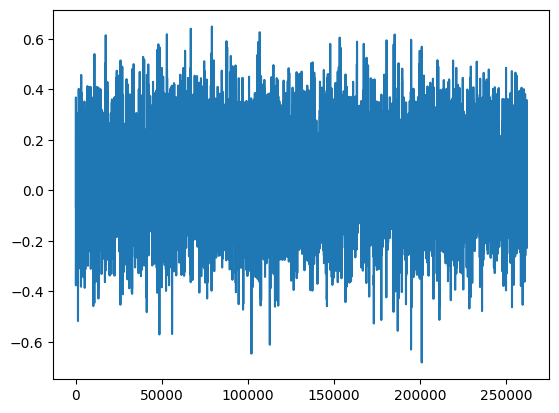

In [ ]:
vae.eval()
inp = next(iter(test_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
with torch.no_grad():
    mu, logvar = vae.encode(inp)
    std = torch.exp(0.5 * logvar)
    eps =  torch.randn_like(std)
    z_rep = mu + std * eps
    output_sep = vae.decode(z_rep)
    output, _, _ = vae(inp)
    z = torch.randn((10, *mu.shape[1:]), device=device)
    samples = vae.decode(z)

mse: ndarray = ((output.squeeze(1).cpu().numpy()-inp.squeeze(1).cpu().numpy()) ** 2).mean(axis = 0)
psnr = 10 * np.log10(1 / mse)
print(np.sum(psnr) / psnr.shape[0])
vae.train()
print(output.shape, samples.shape)
print(output[15][0].cpu().numpy().shape)
AudioData(output[15][0].cpu().numpy()).save_audio_file("Results/VAE4_Test2.wav")
plt.plot(output[15][0].cpu().numpy())
plt.show()
AudioData(output_sep[2][0].cpu().numpy()).save_audio_file("Results/VAE4_Test2_sep.wav")
plt.plot(output_sep[2][0].cpu().numpy())
plt.show()
AudioData(samples[1][0].cpu().numpy()).save_audio_file("Results/VAE4_Test2_sample.wav")
plt.plot(samples[1][0].cpu().numpy())
plt.show()

In [ ]:
def generate_latent_repr(vq_vae: nn.Module, data: Dataset, batch_size: int = 24, device: str = "cpu") -> Dataset:
    data_loader = DataLoader(data, batch_size=batch_size)
    converted_data = []
    vq_vae.eval()
    for b,_ in (data_loader):
        _, q_z, _, _ = vq_vae(b.unsqueeze(1).to(device))
        converted_data.append(q_z)
    vq_vae.train()
    new_data = torch.cat(converted_data, dim=0)
    return AudioDataset(new_data, data_type=torch.long)

In [ ]:
transposed_ds = generate_latent_repr(vq_vae, test_dataset, 24, device)
transposed_dl = DataLoader(transposed_ds, batch_size, shuffle=False)

NameError: name 'vq_vae' is not defined

In [ ]:
idx = 16
inp = next(iter(transposed_dl))[0].to(device)
inp_true = next(iter(test_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
vq_vae.eval()
with torch.no_grad():
    outp = vq_vae.decode(inp)
AudioData(inp_true[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_true_{}.wav".format(idx))
AudioData(outp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_split_{}.wav".format(idx))

torch.Size([48, 32768])


In [ ]:
idx = 0
n = 5000
vq_vae.eval()
inp = next(iter(test_dataloader))[0].unsqueeze(1).to(device)#next(iter(val_dataloader))[0].unsqueeze(1).to(device)
print(inp.shape)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
    q_z[idx, -n:] = torch.randint(low=0, high=2048, size=(n,))
    print(q_z.shape)
    outp = vq_vae.decode(q_z)

print(f"L1 Error True-Out: {np.sum(np.abs(inp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e} Out-Split Out:{np.sum(np.abs(outp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e}")
#AudioData(inp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_inp_{}.wav".format(idx))
#AudioData(output[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_out_{}.wav".format(idx))
#AudioData(outp[idx][0].cpu().numpy()).save_audio_file("Results/VQVAE2_Test_out_split_{}.wav".format(idx))
plt.plot(inp[idx][0].cpu().numpy())
plt.show()
plt.plot(output[idx][0].cpu().numpy())
plt.show()
plt.plot(outp[idx][0].cpu().numpy())
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
